In [1]:
# main_vac_osc script 

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Pauli, Statevector, Operator
from scipy.interpolate import UnivariateSpline
from qiskit_ibm_runtime.fake_provider import FakeManilaV2 # Retired quantum processor
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService

import sys
import os

In [22]:
backend_name = "aer"  #manila, aer, ionq(ideal simulator non-native gateset), ionq_native (ideal simulator native gateset), ionq_qpu (ionq device non-native gateset), ionq_noisy_sim (noisy simulator non-native gateset), ibm 
trotter_order= "first" #first, second

In [23]:
import qiskit 
qiskit.version.get_version_info() 

'1.1.1'

In [24]:
import qiskit_ibm_runtime 
qiskit_ibm_runtime .version.get_version_info() 

'0.34.0'

In [25]:

#ionq backend start
from qiskit import transpile

# Load the API key from the environment variable
api_key = os.getenv('IONQ_API_KEY')
from qiskit_ionq import IonQProvider
# provider = IonQProvider()
# api_key = "zneojFDA2Je63szoO1GYFi7EwQO9FEnQ"
api_key = "dyqcuoaSoGAdBGbuxj05KL4zvK4OU2Np" #for project csc-500
provider = IonQProvider(api_key)
print(provider.backends())

[<IonQSimulatorBackend('ionq_simulator')>, <IonQQPUBackend('ionq_qpu')>]


In [26]:
# Determine the correct path for the 'src' directory
if '__file__' in globals():
    # Running as a script
    src_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', 'src'))
else:
    # Running in an interactive environment like Jupyter Notebook
    src_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

sys.path.append(src_dir)

In [27]:
from hamiltonian import construct_hamiltonian
from evolve import evolve_and_measure_circuit
from meas_counts import meas_counts
from sigma_statistics import calc_mean_and_sigma
from constants import hbar, c , eV, MeV, GeV, G_F, kB

In [28]:

def initialize_parameters():
    N_sites = 4  # Number of qubits
    delta_m_squared = np.pi
    omega_a = np.full(N_sites // 2, delta_m_squared)
    omega_b = np.full(N_sites // 2, delta_m_squared)
    omega = np.concatenate((omega_a, omega_b))
    shots = 1024
    trotter_steps= 10 # Number of Trotter steps per time step
    if backend_name == 'manila':
        backend = FakeManilaV2()
    elif backend_name == 'aer':
        backend = AerSimulator(method='automatic')
    elif backend_name == 'ibm':
        # Define the service to access IBM Quantum systems.
        service = QiskitRuntimeService()
        backend = service.least_busy(operational=True, simulator=False)
    elif backend_name == 'ionq_qpu':
            backend = provider.get_backend("ionq_qpu.forte-1") # qpu.aria-1 # qpu.aria-2 #qpu.forte-1 whichever one is available
    elif backend_name == 'ionq_native': 
            backend = provider.get_backend("simulator", gateset="native")
    elif backend_name == 'ionq_noisy_sim':
            backend = provider.get_backend("simulator")
            backend.set_options(noise_model="aria-1") # aria-1, forte-1, aria-2
    elif backend_name == 'ionq': 
            backend = provider.get_backend("simulator")

        
    optimization_level = 1
    tolerance = 5e-1
    τ = 0.05  # Time step
    ttotal = 5  # Total time
    times = np.arange(0, ttotal, τ)  # Define time steps
    Δx = 1E-3 # length of the box of interacting neutrinos at a site in cm #variable
    L = 1 # cm # not being used in this test but defined to keep the evolve function arguments consistent.
    Δp = L # width of shape function # not being used in this test but defined to keep the evolve function arguments consistent.
    t1 = 0.0084003052 #choose initial time for growth rate calculation #variable, not being used in this test
    t2 = 0.011700318 #choose final time for growth rate calculation #variable, not being used in this test
    theta_nu = np.pi / 4  # mixing_angle in radians
    # Initialize an array of zeros for all N_sites particles
    mu = np.zeros(N_sites)

    # Create an array of dimension N and fill it with the value 1/(sqrt(2) * G_F). This is the number of neutrinos.
    N = mu * np.full(N_sites, (Δx**3) / (np.sqrt(2) * G_F * N_sites))
    # Create a B vector which would be same for all N particles
    B = np.array([np.sin(2 * theta_nu), 0, -np.cos(2 * theta_nu)])
    B = B / np.linalg.norm(B)

    # Generate x, y, and z arrays
    x = np.random.rand(N_sites)
    y = np.random.rand(N_sites)
    z = np.zeros(N_sites)

    # Generate an Nx3 array for p with ones as values
    p = np.ones((N_sites, 3))

    # All of the sites are neutrinos, energy_sign array
    energy_sign = np.ones(N_sites)
    #modify this shape_name dict thing
    shape_name = 1  # variable.  #Select a shape function based on the shape_name variable form the list defined in dictionary in shape_func file


    return N_sites, theta_nu, omega, B, N, x, p, energy_sign, Δx, Δp, L, delta_m_squared, shape_name , shots, trotter_steps, backend, tolerance, τ, times, ttotal, optimization_level



In [29]:

def simulate(times, omega, N_sites,  theta_nu, backend, shots, τ, ttotal,optimization_level,N, B, Δx, p, tolerance, trotter_steps,trotter_order):
    sigma_z_values = []
    expected_sz_array = []

    for t in times:
        expected_sz = [-1 * np.cos(omega_i * t) for omega_i in omega]
        expected_sz_array.append(np.mean(expected_sz) if expected_sz else None)
        if backend_name == 'aer':
            counts_z, isa_circuit_z, density_matrix = meas_counts(t, N, omega, B, N_sites, Δx,  p,theta_nu, trotter_steps, trotter_order, 'Z', backend_name, backend,optimization_level, shots)
        else:
            counts_z, isa_circuit_z = meas_counts(t, N, omega, B, N_sites, Δx,  p,theta_nu, trotter_steps, trotter_order, 'Z', backend_name, backend,optimization_level, shots)
        sigma_z, std_sigma_z = calc_mean_and_sigma(counts_z, shots, 'Z')
                
        print(f"t: {t}, sigma_z: {sigma_z}")
        sigma_z_values.append(sigma_z)
    
    assert all(abs(np.array(sigma_z_values) - np.array(expected_sz_array)) < tolerance), "Assertion failed: values differ more than tolerance"
    return sigma_z_values, expected_sz_array, isa_circuit_z

In [30]:

def plot_results(times, sigma_z_values, expected_sz_array, N_sites):
    plt.plot(times, sigma_z_values, label='Simulated $\sigma_z$')
    plt.plot(times, expected_sz_array, label='Expected $\sigma_z$', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('$\sigma_z$')
    plt.title(f'$\sigma_z$ vs Time ({N_sites} Qubits, $H_{{vac}}$ Term)')
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.savefig('vac_osc.pdf')
    plt.show()

Shot counts after transpilation :  {'1': 1024}
Density Matrix:
DensityMatrix([[ 0.00000000e+00+0.00000000e+00j,
                 0.00000000e+00+0.00000000e+00j,
                 0.00000000e+00+0.00000000e+00j,
                 0.00000000e+00+0.00000000e+00j,
                 0.00000000e+00+0.00000000e+00j,
                 0.00000000e+00+0.00000000e+00j,
                 0.00000000e+00+0.00000000e+00j,
                 0.00000000e+00-0.00000000e+00j,
                 0.00000000e+00+0.00000000e+00j,
                 0.00000000e+00+0.00000000e+00j,
                 0.00000000e+00+0.00000000e+00j,
                 0.00000000e+00-0.00000000e+00j,
                 0.00000000e+00+0.00000000e+00j,
                 0.00000000e+00+0.00000000e+00j,
                 0.00000000e+00+0.00000000e+00j,
                 0.00000000e+00-0.00000000e+00j],
               [ 0.00000000e+00+0.00000000e+00j,
                 3.74939946e-33+0.00000000e+00j,
                 0.00000000e+00+0.00000000e+00j,
     

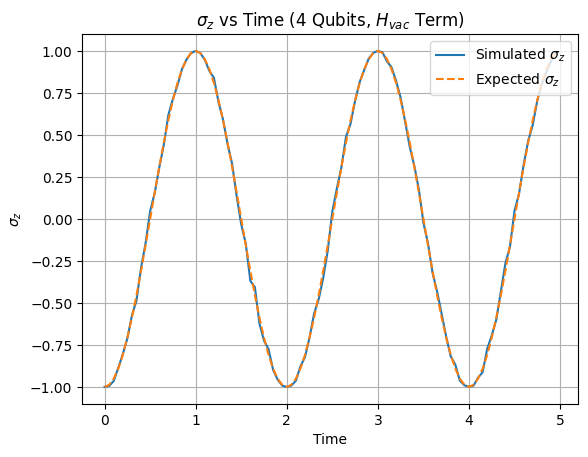

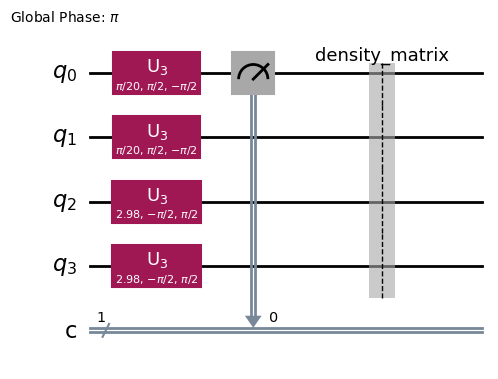

In [31]:
N_sites, theta_nu, omega, B, N, x, p, energy_sign, Δx, Δp, L, delta_m_squared, shape_name , shots, trotter_steps, backend, tolerance, τ, times, ttotal, optimization_level=initialize_parameters()
sigma_z_values, expected_sz_array, circuit = simulate(times, omega, N_sites,  theta_nu, backend, shots, τ, ttotal,optimization_level,N, B, Δx, p, tolerance, trotter_steps,trotter_order)
plot_results(times, sigma_z_values, expected_sz_array, N_sites)
circuit.draw(output="mpl")
    